In [9]:
import os
import json
import re
import pandas as pd
import numpy as np
from kiwipiepy import Kiwi
from datetime import datetime

# Data load

In [10]:
def data_load(name):
    with open(f'crawl_result/{name}.json','r',encoding='utf-8')as f:
        data=json.load(f)
        DF=pd.DataFrame(data['data'])
    return DF

In [11]:
QA=data_load('wineQ&A_text')
rec=data_load('wine_recommend_text')

In [224]:
def clean_text(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    
    text=emoji_pattern.sub(r'', text)
    re_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),|]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    text = re.sub(re_pattern, 'url', text)
    text = re.sub('\([^)]*\)', ',', text)
    text = re.sub('\[[^)]*\]', ',', text)
    text=re.sub('[^ㄱ-ㅎ ㅏ-ㅣ가-힣A-Za-z0-9!?.,~]+',' ',text)
    text=re.sub('[\\s+ *]',' ',text)
    return text

In [225]:
def cleaning(DF):
    DF['clean_content']=DF.본문.apply(lambda x:clean_text(x))
    DF['clean_title']=DF.제목.apply(lambda x:clean_text(x))
    DF['contents']=DF.clean_title+DF.clean_content
    return DF

In [226]:
QA=cleaning(QA)
REC=cleaning(rec)

In [164]:
QA['date']=QA.날짜.apply(lambda x: datetime.strptime(''.join(x.split('.')[:3]),'%Y%m%d'))

In [16]:
Date_count=QA.groupby('date').count().loc[:,'본문']

In [17]:
import chart_studio.plotly.plotly as py
import cufflinks as cf
cf.go_offline(connected=True)

In [30]:
Date_count.iplot(kind='bar',colors='Red')

In [39]:
Date_count.var()

45.2910899142265

In [45]:
import matplotlib.font_manager as font_manager

font_list = font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

# 전체개수
print(len(font_list)) 

# 처음 10개만 출력
font_list[:10]

747


['/opt/X11/share/system_fonts/Supplemental/NotoSansLisu-Regular.ttf',
 '/opt/X11/share/system_fonts/Supplemental/Arial Unicode.ttf',
 '/opt/X11/share/system_fonts/Supplemental/Sinhala MN.ttc',
 '/opt/X11/share/system_fonts/Supplemental/NotoSansLimbu-Regular.ttf',
 '/System/Library/Fonts/Supplemental/Arial Narrow Bold Italic.ttf',
 '/System/Library/Fonts/AquaKana.ttc',
 '/System/Library/Fonts/Supplemental/Webdings.ttf',
 '/System/Library/Fonts/Supplemental/PTSans.ttc',
 '/opt/X11/share/system_fonts/Supplemental/NotoSansTagbanwa-Regular.ttf',
 '/opt/X11/share/system_fonts/Apple Braille Pinpoint 6 Dot.ttf']

In [230]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

def show_contents_length(DF):
    font_name = font_manager.FontProperties(fname='/System/Library/Fonts/Supplemental/Arial Narrow Bold Italic.ttf'
                                           ).get_name()
    rc('font', family=font_name,size=15)
    plt.figure(figsize=(10, 8))
    print('컨텐츠의 최대 길이 :',max(len(l) for l in  DF.contents))
    print('컨텐츠의 평균 길이 :',sum(map(len, QA.contents))/len(DF.contents))
    plt.hist([len(s) for s in DF.contents], bins=50,color='#d62728')
    plt.xlabel('length of contents')
    plt.ylabel('number of contents')
    plt.show()

컨텐츠의 최대 길이 : 2102
컨텐츠의 평균 길이 : 165.68003341687552


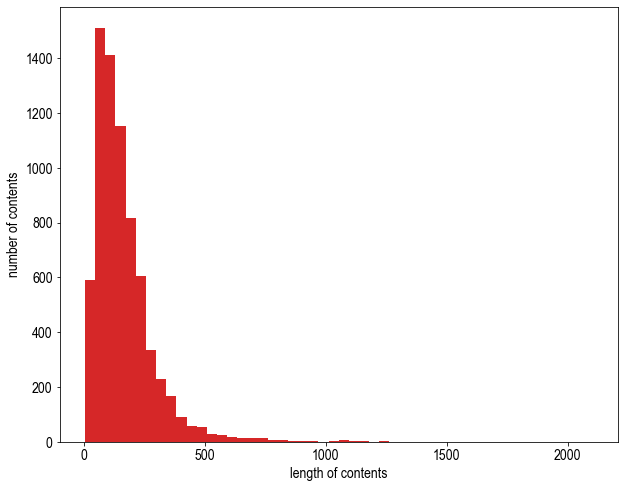

In [231]:
show_contents_length(QA)

# Tokeninzing

In [300]:
def Tokeninzing(DF):
    stopword=[ '와인','마시다','하다','있다'
               '댓글', '글','답변','소통','등업',
               '이렇다','대부분','그렇다','그러다',
                '감사', '되다', '등급', '기본', '안내', '규정', '체계'
               '와쌉','계시다','사람','읽다',
               '가능','가다','가요','가져가다','가지다','그러다']
    kiwi = Kiwi(num_workers=16)
    kiwi.prepare()
    E=[]
    e=[]
    for each_doc in kiwi.analyze(DF['contents'], top_n=1):
        for each_word in each_doc[0][0]:
            if each_word[0] not in stopword:
                if ('VV' in each_word[1]) or ('VA' in each_word[1]):
                    word=each_word[0] + '다'
                    if word not in stopword:
                        e.append(word)
                if ('NNG' in each_word[1]) or ('NNP' in each_word[1]):
                    e.append(each_word[0])
            else:
                pass
        E.append(e)
        e=[]
    temp_title=E
        
#     temp_title = [[each_word[0] if ('NNG' in each_word[1]) or ('NNP' in each_word[1])
#                   else each_word[0] + '다' if ('VV' in each_word[1]) or ('VA' in each_word[1])
#                   else None for each_word in each_doc[0][0]]
#                   for each_doc in kiwi.analyze(DF['contents'], top_n=1)]
    target_title = [[each_word for each_word in each_doc if each_word] for each_doc in temp_title]
    DF['token']=target_title
    return DF

In [301]:
QA=Tokeninzing(QA)
REC=Tokeninzing(REC)

In [306]:
QA['corpus']=QA.token.apply(lambda x: ' '.join(x))
REC['corpus']=REC.token.apply(lambda x: ' '.join(x))

In [295]:
QA['pain']=QA.contents.apply(lambda x :'pain' if len(re.findall('(ㅠㅠ)',x))!=0 else '')

In [ ]:
"# from wordcloud import WordCloud\n",
"# import matplotlib.pyplot as plt\n",

"# wordclouds=WordCloud(width=800,height=800,background_color='white',colormap='Greens')\n",
"# from collections import Counter\n",
"# count=Counter(text)\n",
"# fig=plt.figure(figsize=(10,10))\n",
"# plt.imshow(wordclouds.to_array())\n",
"# plt.show()"

In [307]:
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

def TFIDF(DF):
    tfidv = TfidfVectorizer(min_df=0.01).fit(DF.corpus)
    #tfidf = TfidfVectorizer(max_features = 100, max_df=0.95, min_df=0).fit_transform(DF.corpus)# 상위 100개
    TFIDF=tfidv.transform(DF.corpus)
    #data_array = TFIDF.toarray()
    #text=tfidv.get_feature_names()
    return tfidv,TFIDF
    
def Tsne(tfidv,TFIDF,perplexity,n_classes):
    colors = 'firebrick darksalmon lightseagreen'.split()
    tsne = TSNE(n_components=2, n_iter=10000, verbose=1 ,perplexity= perplexity)
    rc('font', family='AppleGothic')
    Z = tsne.fit_transform(TFIDF.toarray().T)
    print(Z[0:5])
    print('Top words: ',len(Z))
    tfidf_dict = tfidv.get_feature_names()
    plt.figure(figsize=(10, 8))
    plt.scatter(Z[:,0], Z[:,1])
    for i in range(len(tfidf_dict)):
        plt.annotate(s=tfidf_dict[i].encode("utf8").decode("utf8"), xy=(Z[i,0], Z[i,1]))
        plt.draw()
    
    #for c in range(n_classes):
    #         idx = np.where(data == c)[0]
    #         Z_ = Z[idx]
    #         p.scatter(z_[:,0], z_[:,1], fill_color=colors[c], line_color=colors[c])    
    #     show(p)"

[t-SNE] Computing 4 nearest neighbors...
[t-SNE] Indexed 291 samples in 0.045s...
[t-SNE] Computed neighbors for 291 samples in 0.819s...
[t-SNE] Computed conditional probabilities for sample 291 / 291
[t-SNE] Mean sigma: 0.356004
[t-SNE] KL divergence after 250 iterations with early exaggeration: 147.813873
[t-SNE] KL divergence after 5000 iterations: 3.303066
[[-11.072511   -34.83629   ]
 [ 18.337965   -22.477896  ]
 [  0.43084162  -3.2029672 ]
 [  1.0595847  -49.628345  ]
 [ 27.458431   -10.110942  ]]
Top words:  291


<ipython-input-252-f111bad66800>:24: MatplotlibDeprecationWarning:

The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.

/Users/sujin/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning:

Glyph 8722 missing from current font.

/Users/sujin/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning:

Glyph 8722 missing from current font.



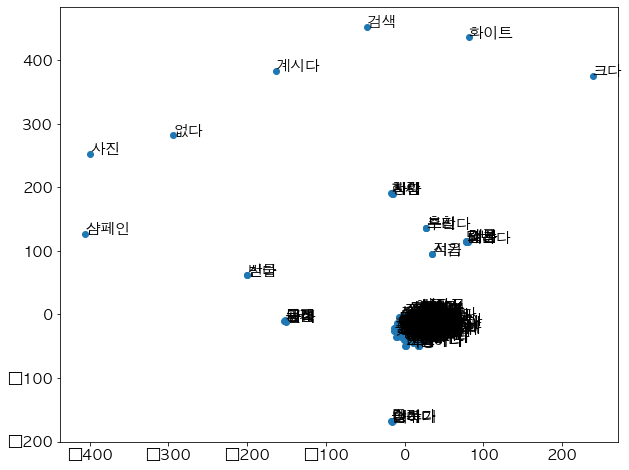

In [262]:
Tsne(TFIDF(QA)[0],TFIDF(QA)[1],1,3)

In [265]:
# words_list, TFIDF=drop_certain_words(np.array(TFIDF(QA)[0].get_feature_names()),
#                                      TFIDF(QA)[1],['와인','마시다','하다','있다'
#                                                    '댓글', '글','답변','소통','등업'
#                                                    '이렇다','대부분','그렇다','그러다',
#                                                    '와쌉','계시다','사람','읽다',
#                                                    '가능','가다','가요','가져가다','가지다'])

In [263]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
    
def plot_2d_graph(vocabs, xs, ys):
    plt.figure(figsize=(20 ,20))
    rc('font', family='AppleGothic')
    rc('font', size=15)
    plt.scatter(xs, ys, marker = 'o')
    for i, v in enumerate(vocabs):
        plt.annotate(v, xy=(xs[i], ys[i]))

def Token2vec(DF,mincount):
    model = Word2Vec(sentences = DF.token, vector_size = 3, min_count = mincount, workers = 6, sg = 0)
    word_vectors = model.wv
    pca = PCA(n_components=2)
    vocabs = list(model.wv.index_to_key)
    word_vocab_list = [model.wv[v] for v in vocabs]
    xys = pca.fit_transform(word_vocab_list)
    xs = xys[:,0]
    ys = xys[:,1]
    plot_2d_graph(vocabs, xs, ys)

/Users/sujin/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning:

Glyph 8722 missing from current font.

/Users/sujin/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning:

Glyph 8722 missing from current font.



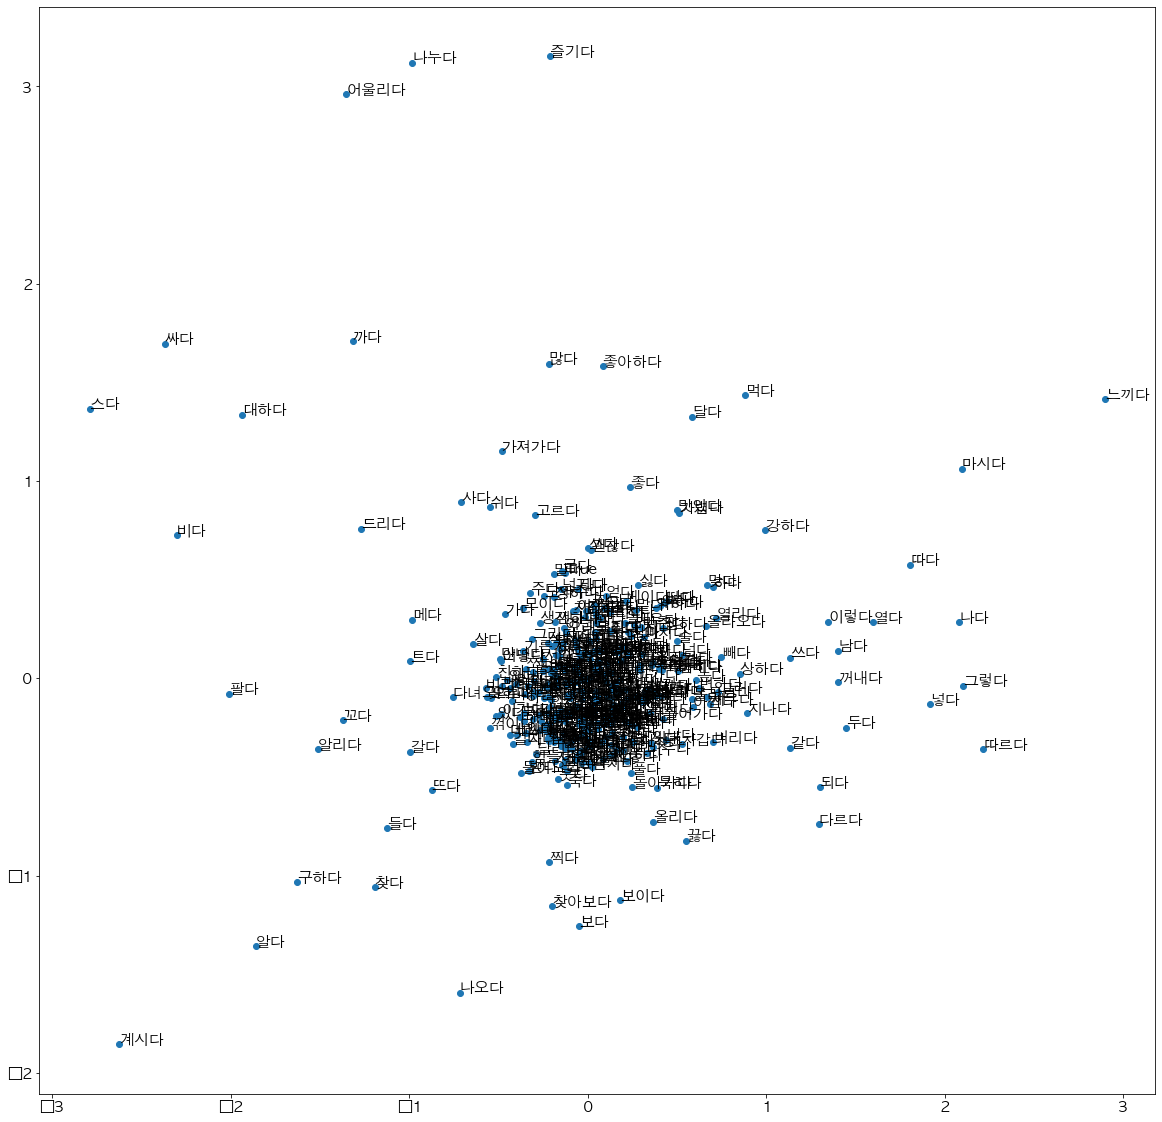

In [267]:
Token2vec(QA,10)

In [308]:
from sklearn.decomposition import LatentDirichletAllocation
tfidv,tfidf=TFIDF(QA)
lda=LatentDirichletAllocation(n_components=3)
lda.fit(tfidf)

LatentDirichletAllocation(n_components=3)

In [309]:
def drop_certain_words(corpus, sparse_matrix, drop_words):
    drop_words_index = [np.where(corpus == word)[0][0] for word in drop_words]
    to_keep = sorted(set(range(sparse_matrix.shape[1])) - set(drop_words_index))
    corpus = corpus[to_keep]
    sparse_matrix = sparse_matrix[:, to_keep]
    return corpus, sparse_matrix

In [310]:
def display_topics(model, feature_names, no_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        important_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        print("Topic %d:\" % topic_idx")
        print(",".join(important_words))
        topics.append(important_words)
    return topics

In [311]:
display_topics(lda,tfidv.get_feature_names(),10)

Topic %d:" % topic_idx
먹다,어떻다,받다,드리다,있다,알다,선물,들다,부탁,어울리다
Topic %d:" % topic_idx
있다,가격,같다,사다,보다,알다,구매,괜찮다,좋다,정도
Topic %d:" % topic_idx
싸다,대하다,댓글,보관,클릭,체계,셀러,행사,있다,샴페인


[['먹다', '어떻다', '받다', '드리다', '있다', '알다', '선물', '들다', '부탁', '어울리다'],
 ['있다', '가격', '같다', '사다', '보다', '알다', '구매', '괜찮다', '좋다', '정도'],
 ['싸다', '대하다', '댓글', '보관', '클릭', '체계', '셀러', '행사', '있다', '샴페인']]

In [329]:
import pyLDAvis.gensim
from gensim import corpora
import gensim

/Users/sujin/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



ModuleNotFoundError: No module named 'pyLDAvis.gensim'

# gensim

In [ ]:
import pyLDAvis.gensim
from gensim import corpora
import gensim

dictionary = corpora.Dictionary(QA.tocken)
corpus = [dictionary.doc2bow(text) for text in Token]

NUM_TOPICS = 3 #20개의 토픽, k=20
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
topics = ldamodel.print_topics(num_words=4)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis)